In [1]:
import xgboost as xgb
import awkward as ak
import matplotlib.pyplot as plt
import hist
import warnings
import pickle
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import numpy as np
import pickle
import mplhep as hep
from matplotlib.lines import Line2D
import gc

In [2]:
plt.style.use(hep.style.CMS)

In [3]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

In [4]:
hgg_ratios=160
with open(f'/scratch365/cmoore24/training/hgg/final_draft_dev/QCDgg/results/ratio_lists/{hgg_ratios}.pkl', 'rb') as f:
    hgg_feature_names = pickle.load(f)

In [5]:
columns = ['ungroomed_ecfs','groomed_ecfs','goodjets']

In [6]:
samples = {}
path = '/project01/ndcms/cmoore24/skims/analysis_skims/2017/trijet/mc/'
for i in os.listdir(path):
    if ('qcd' in i) or ('qq' in i) or ('diboson' in i) or ('ttboosted' in i) :
    # if ('ht_qcd' in i) or ('qq' in i):
        samples[i] = ak.from_parquet(f'{path}/{i}/*', columns=columns)

In [7]:
samples_data = {}
path = '/project01/ndcms/cmoore24/skims/analysis_skims/2017/trijet/data/'
for i in os.listdir(path):
    samples_data[i] = ak.from_parquet(f'{path}/{i}/*', columns=columns)

In [8]:
data = ak.concatenate([samples_data[i] for i in samples_data])
del(samples_data)
gc.collect()

2

In [9]:
train = 'kinematics'
trees = '1000'

In [10]:
path = f'/scratch365/cmoore24/training/hgg/quark_gluon/output/{train}/{trees}'

In [11]:
bst = xgb.Booster()
bst.load_model(f'{path}/bdt_model.json')

In [12]:
gg_feature_names = [
    'area',
    'eta',
    'mass',
    'msoftdrop',
    'n2b1',
    'n3b1',
    'phi',
    'pt',
    'tau1',
    'tau2',
    'tau3',
    'tau4',
]

In [13]:
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [14]:
for i in samples:
    np_stack = np.column_stack([ak.to_numpy(samples[i].goodjets[feature]) for feature in gg_feature_names])
    np_stack = scaler.transform(np_stack)
    stack_xgb = xgb.DMatrix(np_stack, feature_names=gg_feature_names)
    samples[i]['goodjets','gluon_score'] = bst.predict(stack_xgb)
    # samples[i] = samples[i][ak.flatten(samples[i].goodjets.gluon_score >= 0.6)]

In [15]:
np_stack = np.column_stack([ak.to_numpy(data.goodjets[feature]) for feature in gg_feature_names])
np_stack = scaler.transform(np_stack)
stack_xgb = xgb.DMatrix(np_stack, feature_names=gg_feature_names)
data['goodjets','gluon_score'] = bst.predict(stack_xgb)
# data = data[ak.flatten(data.goodjets.gluon_score >= 0.6)]

In [16]:
def add_ratios(ratio, array):
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[4:dash]
    denominator = ratio[dash+1:asterisk]
    exponent = float(ratio[asterisk+2:].replace('_','.'))
    if ratio[:3] == 'grm':
        num_ecf = array.groomed_ecfs[numerator]
        den_ecf = array.groomed_ecfs[denominator]
    elif ratio[:3] == 'ugm':
        num_ecf = array.ungroomed_ecfs[numerator]
        den_ecf = array.ungroomed_ecfs[denominator]
    ecf_ratio = (num_ecf / (den_ecf**exponent))   
    return ecf_ratio

In [17]:
ratios = 160
model_path = f'/scratch365/cmoore24/training/hgg/final_draft_dev/QCDgg/outputs/{ratios}'

In [18]:
bst = xgb.Booster()
bst.load_model(f'{model_path}/bdt_model.json')

In [19]:
ecf_scaler = f'{model_path}/scaler.pkl'
with open(ecf_scaler, 'rb') as f:
    ecf_scaler = pickle.load(f)

In [20]:
feature_names = bst.feature_names

In [21]:
ecf_ratios_data = {}
for i in feature_names:
    ecf_ratios_data[i] = add_ratios(i, data)

In [22]:
ecf_ratios_data = ak.zip(ecf_ratios_data, depth_limit=1)

In [23]:
data_np = np.column_stack([ak.to_numpy(ecf_ratios_data[feature]) for feature in feature_names])
data_np = ecf_scaler.transform(data_np)
data_xgb = xgb.DMatrix(data_np, feature_names=feature_names)
data['goodjets', 'GSscore'] = bst.predict(data_xgb)

In [24]:
for i in samples:

    ecf_ratios_sample = {}
    for j in feature_names:
        ecf_ratios_sample[j] = add_ratios(j, samples[i])
    
    sample_np = np.column_stack([ak.to_numpy(ecf_ratios_sample[feature]) for feature in feature_names])
    sample_np = ecf_scaler.transform(sample_np)
    sample_xgb = xgb.DMatrix(sample_np, feature_names=feature_names)
    samples[i]['goodjets', 'GSscore'] = bst.predict(sample_xgb)

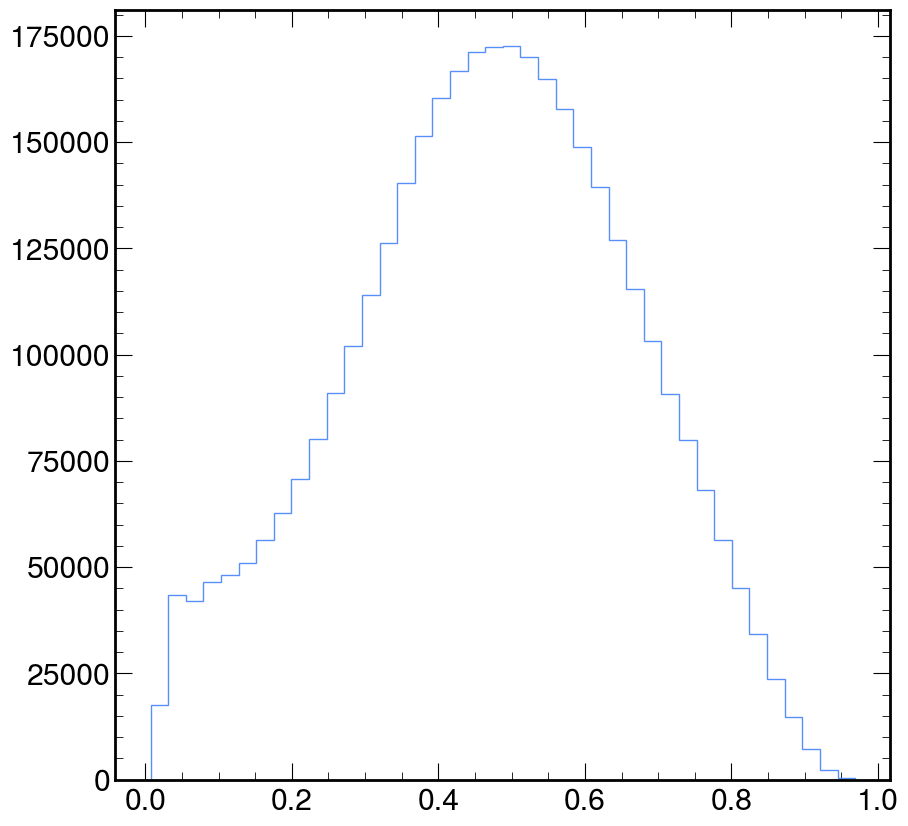

In [25]:
plt.hist(ak.flatten(data.goodjets.GSscore),bins=40, histtype='step')
plt.show()

In [30]:
def apply_gsscore_cut(msoftdrop, gsscore, edges, pass_thresholds):
    m = np.asarray(ak.fill_none(msoftdrop, np.nan), dtype=np.float64)
    s = np.asarray(ak.fill_none(gsscore,   np.nan), dtype=np.float64)
    bin_idx = np.digitize(m, edges, right=True) - 1
    nb = len(edges) - 1
    inbin = (bin_idx >= 0) & (bin_idx < nb)
    thr = np.full_like(m, np.nan, dtype=float)
    fthr = np.full_like(m, np.nan, dtype=float)
    thr[inbin] = pass_thresholds[bin_idx[inbin]]
    finite = np.isfinite(s)
    passed = inbin & finite & (s >= thr)
    failed = inbin & np.isfinite(s) & (s < thr) #& (s >= fthr)
    return passed 

In [26]:
data = data[ak.flatten(data.goodjets.gluon_score >= 0.6)]

In [27]:
for i in samples:
    samples[i] = samples[i][ak.flatten(samples[i].goodjets.gluon_score >= 0.6)]

In [28]:
with open('pass_thresholds2017.pkl','rb') as f:
    pass_threshold = pickle.load(f)

In [31]:
cut_mask = apply_gsscore_cut(data.goodjets.msoftdrop, data.goodjets.GSscore, 
                np.linspace(40, 200, 41), pass_threshold)

In [32]:
data = data[ak.flatten(cut_mask)]

In [33]:
for i in samples:
    samples_cut = apply_gsscore_cut(samples[i].goodjets.msoftdrop,
                                    samples[i].goodjets.GSscore,
                                    np.linspace(40,200,41),pass_threshold)
    samples[i] = samples[i][ak.flatten(samples_cut)]

In [34]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)['2017']
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2
xsecs['diboson_ww'] = xsecs['ww']
xsecs['diboson_wz'] = xsecs['wz']
xsecs['diboson_zz'] = xsecs['zz']

In [47]:
def make_hists(sample, bins):
    new_hist = (hist.Hist.new
        .Reg(28, 68, 180, name=f'msd', label=f'msd', underflow=False, overflow=False)
        .Double())
    new_hist.fill(msd=ak.firsts(sample.goodjets.msoftdrop));
    return new_hist

In [48]:
mc_hists = {}
for i in samples:
    mc_hists[i] = make_hists(samples[i], 40)

In [49]:
for i in mc_hists:
    scale = ((41.5*(xsecs[i]*1000))/totals[i])
    mc_hists[i].view(flow=True)[:] *= scale

In [50]:
qcd = sum([mc_hists[i] for i in mc_hists if 'qcd' in i])
wqq = sum([mc_hists[i] for i in mc_hists if 'wqq' in i])
zqq = sum([mc_hists[i] for i in mc_hists if 'zqq' in i])
ttboosted = sum([mc_hists[i] for i in mc_hists if 'ttboosted' in i])
diboson = sum([mc_hists[i] for i in mc_hists if 'diboson' in i])
mc = qcd + wqq + zqq + ttboosted + diboson

In [51]:
data_hist = make_hists(data, 40)

Text(0.5, 1.0, 'Trijet Region: MC v. Data Comparison')

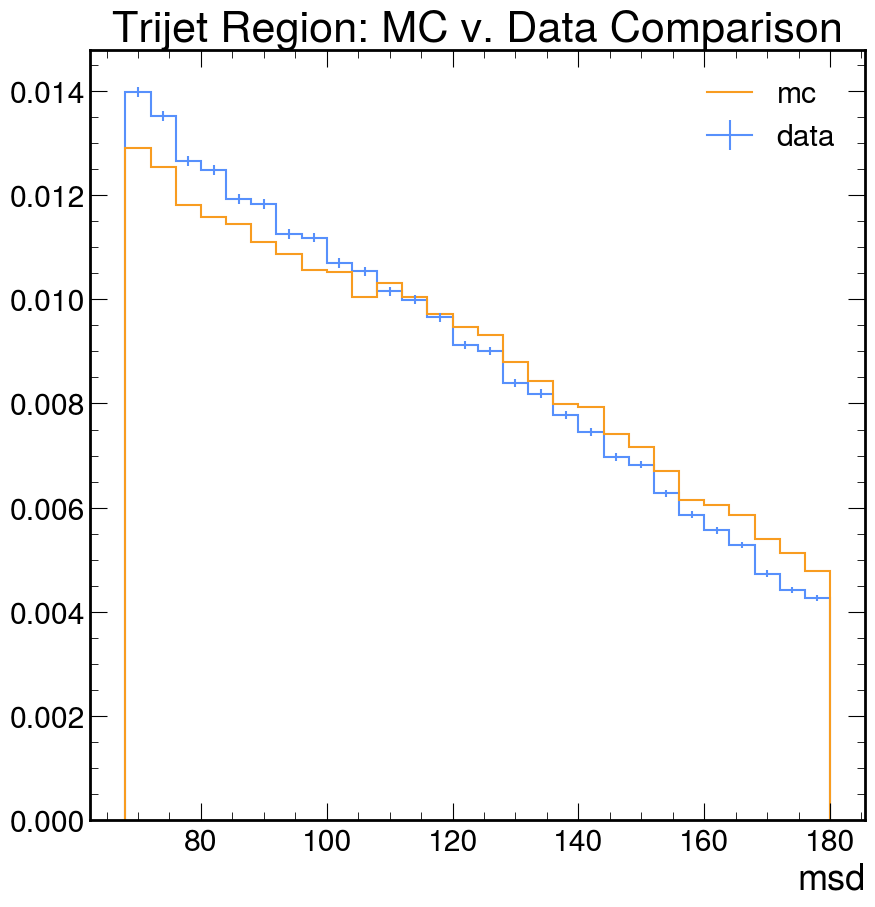

In [52]:
data_hist.plot1d(density=True, label='data')
mc.plot1d(density=True, label='mc')
plt.legend()
plt.title('Trijet Region: MC v. Data Comparison')